In [4]:
import torch
from torch import nn
from torch import optim
import numpy as np
from torch.nn import functional as F
import gym
import torch.multiprocessing as mp #A

class ActorCritic(nn.Module): #B
    def __init__(self):
        super(ActorCritic, self).__init__()
        self.l1 = nn.Linear(4,25)
        self.l2 = nn.Linear(25,50)
        self.actor_lin1 = nn.Linear(50,2)
        self.l3 = nn.Linear(50,25)
        self.critic_lin1 = nn.Linear(25,1)
    def forward(self,x):
        x = F.normalize(x,dim=0)
        y = F.relu(self.l1(x))
        y = F.relu(self.l2(y))
        actor = F.log_softmax(self.actor_lin1(y),dim=0) #C
        c = F.relu(self.l3(y.detach()))
        critic = torch.tanh(self.critic_lin1(c)) #D
        return actor, critic #E

In [6]:
def run_episode(worker_env, worker_model):
    state = torch.from_numpy(worker_env.env.state).float() #A
    values, logprobs, rewards = [],[],[] #B
    done = False
    j=0
    while (done == False): #C
        j+=1
        policy, value = worker_model(state) #D
        values.append(value)
        logits = policy.view(-1)
        action_dist = torch.distributions.Categorical(logits=logits)
        action = action_dist.sample() #E
        logprob_ = policy.view(-1)[action]
        logprobs.append(logprob_)
        state_, _, done, info = worker_env.step(action.detach().numpy())
        state = torch.from_numpy(state_).float()
        if done: #F
            reward = -10
            worker_env.reset()
        else:
            reward = 1.0
        rewards.append(reward)
    return values, logprobs, rewards

In [7]:
def update_params(worker_opt,values,logprobs,rewards,clc=0.1,gamma=0.95):
        rewards = torch.Tensor(rewards).flip(dims=(0,)).view(-1) #A
        logprobs = torch.stack(logprobs).flip(dims=(0,)).view(-1)
        values = torch.stack(values).flip(dims=(0,)).view(-1)
        Returns = []
        ret_ = torch.Tensor([0])
        for r in range(rewards.shape[0]): #B
            ret_ = rewards[r] + gamma * ret_
            Returns.append(ret_)
        Returns = torch.stack(Returns).view(-1)
        Returns = F.normalize(Returns,dim=0)
        actor_loss = -1*logprobs * (Returns - values.detach()) #C
        critic_loss = torch.pow(values - Returns,2) #D
        loss = actor_loss.sum() + clc*critic_loss.sum() #E
        loss.backward()
        worker_opt.step()
        return actor_loss, critic_loss, len(rewards)

In [21]:
mode = ActorCritic()
scores = []

for i in range(1000):
    worker_env = gym.make("CartPole-v1")
    worker_env.reset()
    worker_opt = optim.Adam(lr=1e-4,params=mode.parameters()) #A
    worker_opt.zero_grad()
    worker_opt.zero_grad()
    values, logprobs, rewards = run_episode(worker_env, mode) #B 
    actor_loss,critic_loss,eplen = update_params(worker_opt,values,logprobs,rewards) #C
    scores.append(len(rewards))

Text(0, 0.5, 'Loss')

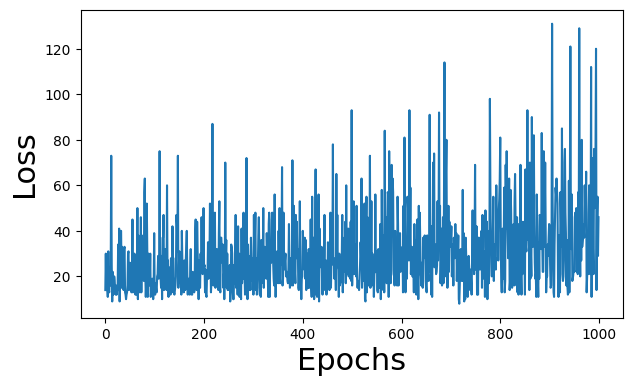

In [24]:
import matplotlib.pyplot as plt
plt.figure(figsize=(7,4))
plt.plot([i for i in range(len(scores))], scores)
plt.xlabel("Epochs",fontsize=22)
plt.ylabel("Loss",fontsize=22)

In [ ]:
### 没有成功